# Homework 7 Problem 1: Find the Clothes 2.0!
We have created another toy dataset that pastes multiple images from the FashionMNIST dataset onto a blank background. The task of interest is to perform semantic segmentation to find where the clothing is located in the image *and also classify the type of clothing* according to the classes in the Fashion MNIST dataset. In standard semantic segmentation terms, we have one background class and ten foreground/object classes. Thus, we are classifying each pixel in the image as belonging to one of 11 classes: background class or one of the object classes.

The below dataset ``SegmentedFashionMNIST`` generates the dataset with (image, label) pairs. For each pixel in the label image, a value of 0 indicates background while a value of $c\geq 1$ corresponds to class $c-1$ in FashionMNIST. You do not need to perform any modifications to the label values, we are just clarifying this point of implementation.

In [214]:
import torch
import torch.nn as nn
import torchvision
import numpy as np

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class SegmentedFashionMNIST(Dataset):
    def __init__(self, N, K, S=128):
        # N is number of images in dataset
        # K is number of FashionMNIST images to copy-paste into each example image
        # S is the square image size
        self.data = torchvision.datasets.FashionMNIST(root='./', download=True)
        self.N = N
        self.K = K
        self.S = S
        self.images, self.targets = self.generate_data()

    def generate_data(self):
        images = []
        targets = []
        for n in range(self.N):
            new_image = torch.zeros((1, self.S, self.S))
            new_label = torch.zeros((1, self.S, self.S))
            grid_size = self.S/np.sqrt(K)
            offset_coordinates = np.random.choice(np.arange(grid_size), size=(self.K, 2))
            random_coordinates = np.zeros((self.K, 2))
            n_cols = int(np.ceil(np.sqrt(K)))
            n_rows = int(np.ceil(K/n_cols))
            k = 0
            for k1 in range(n_rows):
                for k2 in range(n_cols):
                    random_coordinates[k] = np.array([np.clip(k1*grid_size+offset_coordinates[k, 0], 0, self.S-28),
                                                      np.clip(k2*grid_size+offset_coordinates[k, 1], 0, self.S-28)])
                    k += 1
                    if k >= self.K:
                        break
            random_coordinates = random_coordinates.astype(int)
            random_indices = np.random.choice(np.arange(len(self.data)), size=self.K)
            fashion_images = [self.data[random_indices[i]][0] for i in range(self.K)]
            fashion_labels = [self.data[random_indices[l]][1] for l in range(self.K)]
            for k in range(self.K):
                # threshold pixels to mask out objects in FashionMNIST images
                curr_image, curr_label = fashion_images[k], fashion_labels[k]
                curr_image = torchvision.transforms.functional.pil_to_tensor(curr_image)/255
                object_mask = (curr_image > (5/255)).float()
                curr_image *= object_mask
                curr_label_image = torch.ones_like(curr_image)*(curr_label+1)*object_mask
                tl_y, tl_x = random_coordinates[k]
                new_image[0, tl_y:tl_y+28, tl_x:tl_x+28] = new_image[0, tl_y:tl_y+28, tl_x:tl_x+28]*(1-object_mask)+curr_image
                new_label[0, tl_y:tl_y+28, tl_x:tl_x+28] = new_label[0, tl_y:tl_y+28, tl_x:tl_x+28]*(1-object_mask)+curr_label_image
            images.append(new_image)
            targets.append(new_label)
        return images, targets      
    
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx].long()

N = 100 # number of images
K = 5 # number of FashionMNIST objects placed on each image
dataset = SegmentedFashionMNIST(N, K)

Classes present: tensor([0, 2, 5, 8, 9])


(-0.5, 127.5, 127.5, -0.5)

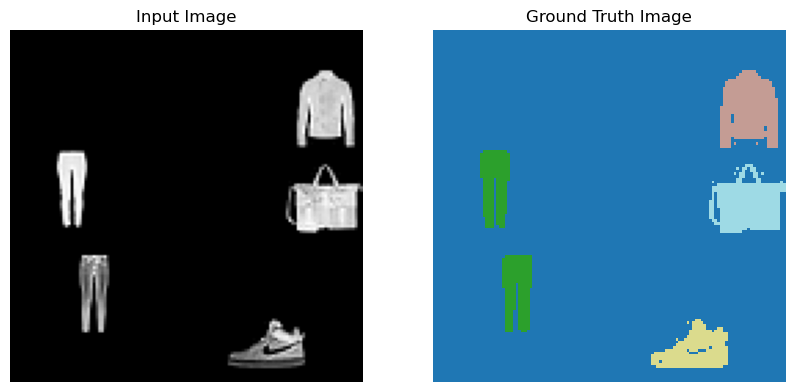

In [215]:
# example image plotting from dataset
import matplotlib.pyplot as plt
img, label = dataset[0]
print('Classes present: {}'.format(torch.unique(label)))

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title('Input Image')
plt.imshow(img.squeeze(0).numpy(), 'gray')
plt.axis(False)
plt.subplot(122)
plt.title('Ground Truth Image')
plt.imshow(label.squeeze(0).numpy(), 'tab20', interpolation='nearest')
plt.axis(False)

## Metrics

Our primary evaluation metric we will use is Intersection over Union (IoU). Let $\mathbf{Y}\in\{0, 1\}^{H\times W}$ be a binary label image and $\hat{\mathbf{Y}}\in\{0, 1\}^{H\times W}$ a binary prediction image. We compute IoU as
$$
\textrm{IoU}=\frac{|\mathbf{Y}\cap\hat{\mathbf{Y}}|}{|\mathbf{Y}\cup\hat{\mathbf{Y}}|}\in[0,1],
$$
where $|\mathbf{X}|$ denotes the cardinality or number of non-zero elements in a matrix, the $\cap$ symbol indicates intersection, and $\cup$ indicates the union operation.

In this application, we have 10 object classes of interest. Thus, we may compute IoU for each of the 10 classes. The target image $\mathbf{Y}_c$ will take value one for pixels that belong to class $c$ and prediction image $\hat{\mathbf{Y}}_c$ will take value one for pixels that the model assigns the highest score/probability to class $c$. We will then calculate 10 IoU values for each class and may evaluate each of these. Altogether, we can average these 10 IoU values to obtain the overall *mean IoU* (mIoU) metric. The below ``iou`` function computes the per-class IoUs for a given batch of predictions and targets/labels. The provided training and evaluation codes also handle the use of this function and plotting of the results. This explanation is given to provide meaning to the evaluation results you produce in this exercise.

In [216]:
from tqdm import tqdm

def iou(preds, targets):
    # preds is size (B, N_classes, H, W) for batch size B
    # targets is size (B, 1, H, W) for batch size B
    N_classes = preds.size(1) # number of items classes + 1 for background
    ious = np.zeros(N_classes) # per-class ious
    counts = np.zeros(N_classes) # number of images in batch with each class
    for b in range(preds.size(0)):
        values, locations = torch.max(preds[b], dim=0)
        # skip background class 0
        for c in range(1, N_classes):
            target_c = (targets[b]==c).float()
            if torch.sum(target_c).item():
                pred_c = (locations==c).float()
                intersection = torch.sum(pred_c*target_c)
                union = torch.sum((pred_c+target_c)>0)
                ious[c] += intersection/union # add to running IOU of class c
                counts[c] += 1 # increment count for class c
    return ious, counts

def training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader):
    loss_values, train_ious, val_ious = [], [], []
    for n in tqdm(range(n_epochs)):
        epoch_loss, epoch_ious, epoch_counts = 0, np.zeros(11), np.zeros(11)
        for x_batch, y_batch in train_loader:
            B = x_batch.size(0)
            N_classes = 11
            # zero out gradients
            optimizer.zero_grad()
            # pass batch to model
            predictions = model(x_batch)
            # calculate loss
            loss = criterion(predictions.view(B, N_classes, -1), y_batch.view(B, -1))
            # backpropagate and update
            loss.backward() # backprop
            optimizer.step()
            # logging to update epoch_loss (add loss value) and epoch_iou (add current batch iou)
            epoch_loss += loss.item()
            ious, counts = iou(predictions, y_batch)
            epoch_ious += ious
            epoch_counts += counts
    
        loss_values.append(epoch_loss/len(train_loader))
        train_ious.append(epoch_ious[1:]/epoch_counts[1:])
        # validation performance
        epoch_val_ious, epoch_val_counts = np.zeros(11), np.zeros(11)
        for x_batch, y_batch in val_loader:
            # don't compute gradients since we are only evaluating the model
            with torch.no_grad():
                # validation batch iou
                predictions = model(x_batch)
                ious, counts = iou(predictions, y_batch)
                epoch_val_ious += ious
                epoch_val_counts += counts
        val_ious.append(epoch_val_ious[1:]/epoch_val_counts[1:])
    return model, loss_values, train_ious, val_ious

## Work to complete for Homework 7 Problem 1

We ask that you implement your own autoencoder model in the below ``MyAutoEncoder`` class and train your model using the provided training code. Experiment with your autoencoder model design, e.g. number of layers, width of layers, activations, pooling, etc., and training algorithm, e.g. learning rate, number of epochs, etc.

### Requested level of performance

A reasonably good CNN for this exercise should be able to achieve over 0.80 training mIoU and over 0.30 validation mIoU. Please keep the overall dataset size $N=100$ with $K=5$ using $50$ training examples and $50$ validation examples. On the homework, we ask you to provide the following pieces of information from your experimentation.

### Objectives for the homework

a) Implement your model in the provided ``MyAutoEncoder`` class. Share a screenshot of or re-create your ``MyAutoEncoder`` implementation, including the values selected for any input parameters to the constructor for your final implementation. **Describe what kinds of architecture choices you tried and any observations you may have made to arrive at this choice.**

b) Share the training loss, training mean IoU, and validation mean IoU plots from the provided code after training your model. **Please also share the number of training epochs and learning rate from your training algorithm.**

c) Share an example of the qualitative results generated by the provided code for one training image and one validation image, i.e. example input image and outputs of your model. Comment on the differences in your model predictions.

In [217]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        # fill this is in as you like!
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU())
        self.decoder = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2))
        self.outconv = nn.Conv2d(32, 11, kernel_size=1, padding=0, stride=1)
        
    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        z = self.outconv(z)
        return z

In [ ]:
# create dataset, do not change this!
N = 100
K = 5
N_train = 50
N_val = 50
dataset = SegmentedFashionMNIST(N, K)
indices = np.random.choice(np.arange(len(dataset)), size=N, replace=False)
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]

# create dataloaders
batch_size = 4
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# create model, fill this in as necessary for your model experimentation
model = MyAutoEncoder() # fill in constructor as necessary for your model

# criterion and optimizer
criterion = nn.CrossEntropyLoss() # cross-entropy loss since each pixel is evaluated by multi-class classification
lr = 3e-2 # tune this
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4) # tune this
n_epochs = 800# tune this

# train
model, loss_values, train_ious, val_ious = training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader)

100%|██████████| 500/500 [32:06<00:00,  3.85s/it]   


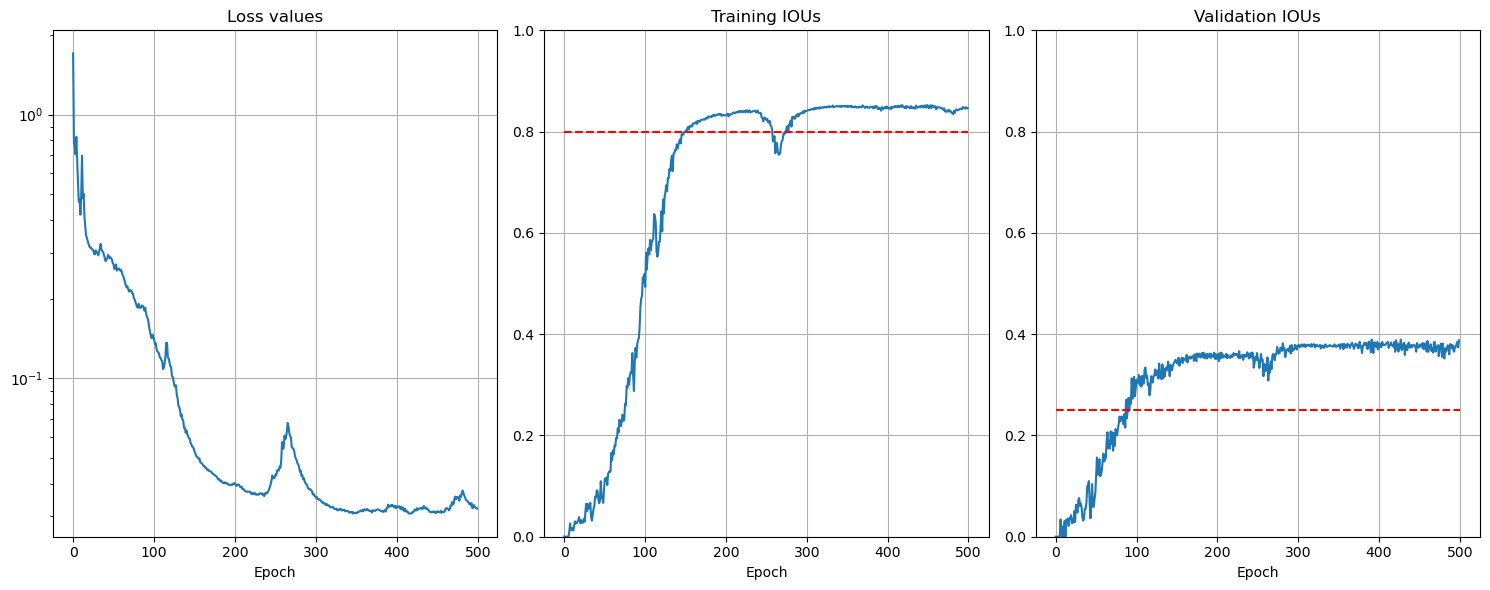

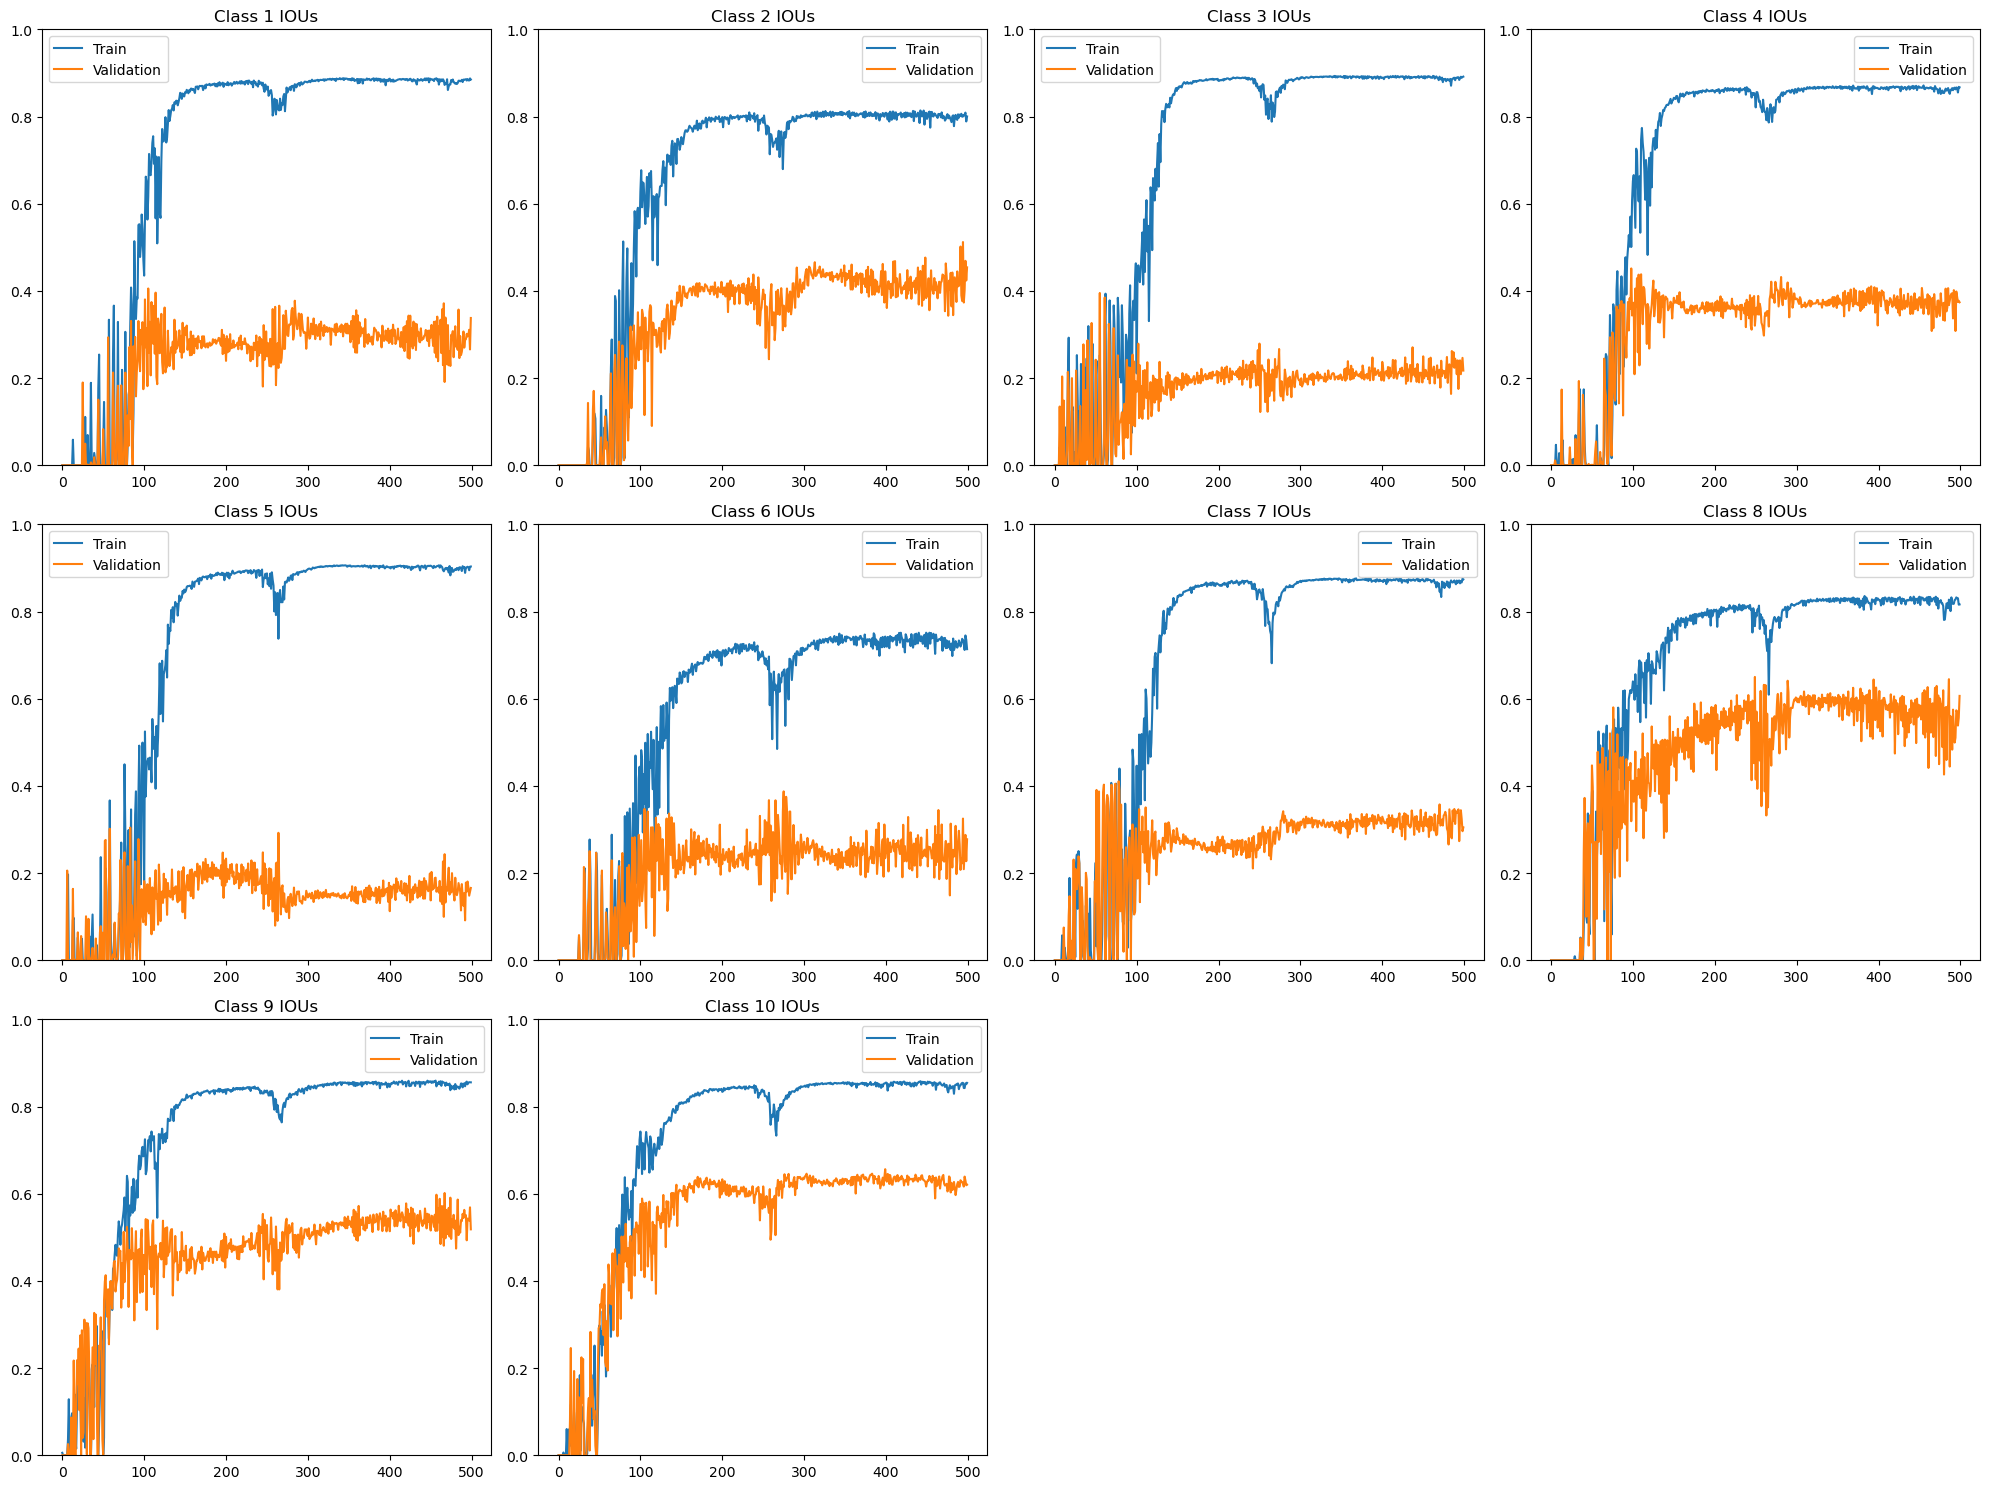

In [219]:
# loss, training mIoU, validation mIoU
mean_train_ious = [np.mean(t) for t in train_ious]
mean_val_ious = [np.mean(v) for v in val_ious]
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(mean_train_ious)
# reference line for 0.8 validation mean IoU
plt.hlines([0.8], 0, len(mean_val_ious), colors='red', linestyles='dashed')
plt.ylim([0, 1])
plt.grid(True)
plt.title('Training IOUs')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(mean_val_ious)
# reference line for 0.25 validation mean IoU
plt.hlines([0.25], 0, len(mean_val_ious), colors='red', linestyles='dashed')
plt.ylim([0, 1])
plt.grid(True)
plt.title('Validation IOUs')
plt.xlabel('Epoch')
plt.tight_layout()

# per class IoUs, not necessary for homework, but provided for those who are interested
plt.figure(figsize=(20, 15))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.plot([t[i] for t in train_ious], label='Train')
    plt.plot([v[i] for v in val_ious], label='Validation')
    plt.ylim([0, 1])
    plt.legend()
    plt.title('Class {} IOUs'.format(i+1))
plt.tight_layout()

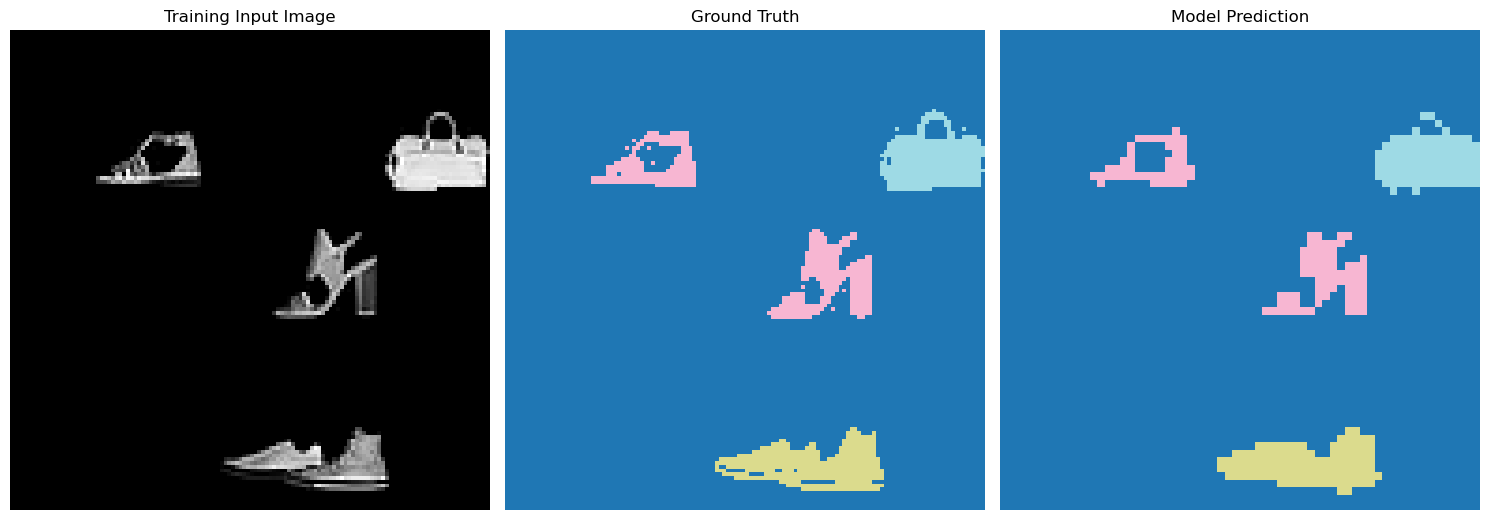

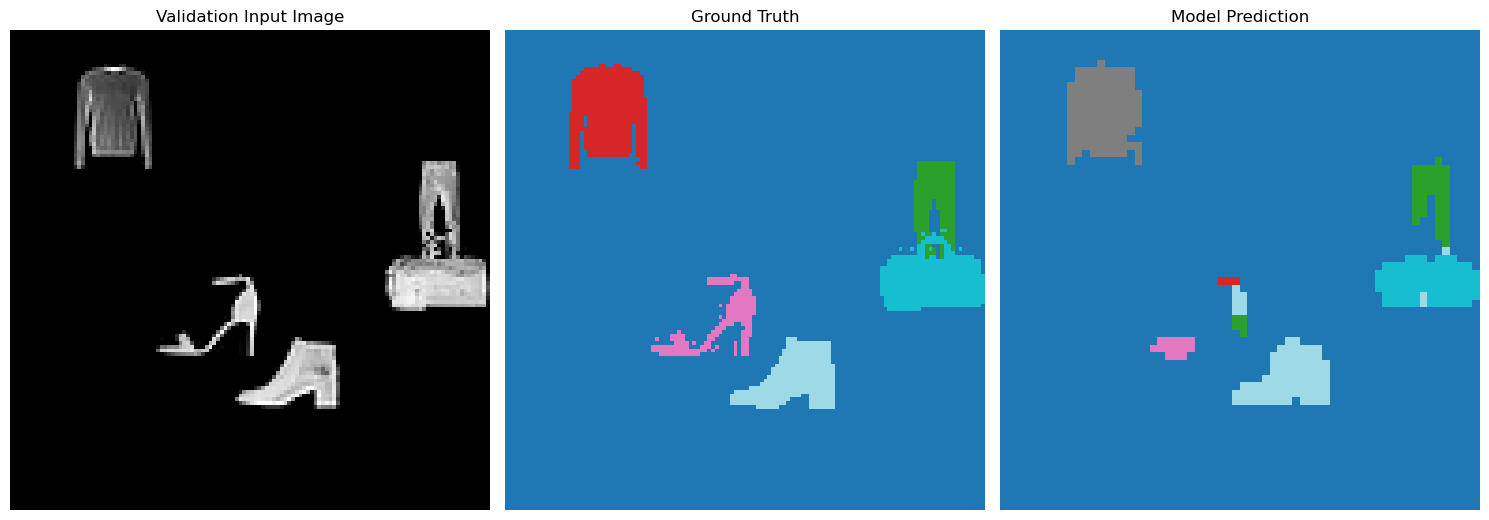

In [220]:
# Part (c): visualize model output
idx = 0# try changing this
train_idx = train_indices[idx]
val_idx = val_indices[idx]

# training image
image, target = dataset[train_idx]
with torch.no_grad():
    # add batch dimension then remove batch dimension after passing to model
    prediction = model(image.unsqueeze(0)).squeeze(0) 
    _, prediction_image = torch.max(prediction, dim=0)

plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(image.squeeze(0).numpy(), 'gray') # remove color channel dimension with .squeeze(0)
plt.axis(False)
plt.title('Training Input Image')
plt.subplot(132)
plt.imshow(target.squeeze(0).numpy(), 'tab20', interpolation='nearest')
plt.axis(False)
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction_image.numpy(), 'tab20', interpolation='nearest')
plt.axis(False)
plt.title('Model Prediction')
plt.tight_layout()

# validation image
image, target = dataset[val_idx]
with torch.no_grad():
    # add batch dimension then remove batch dimension after passing to model
    prediction = model(image.unsqueeze(0)).squeeze(0) 
    _, prediction_image = torch.max(prediction, dim=0)

plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(image.squeeze(0).numpy(), 'gray') # remove color channel dimension with .squeeze(0)
plt.axis(False)
plt.title('Validation Input Image')
plt.subplot(132)
plt.imshow(target.squeeze(0).numpy(), 'tab20', interpolation='nearest')
plt.axis(False)
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction_image.numpy(), 'tab20', interpolation='nearest')
plt.axis(False)
plt.title('Model Prediction')
plt.tight_layout()